- Reference [causalml tutorial](https://causalml.readthedocs.io/en/latest/examples/causal_trees_with_synthetic_data.html)

In [4]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from collections import defaultdict

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.meta import BaseSRegressor, BaseXRegressor, BaseTRegressor, BaseDRRegressor
from causalml.inference.tree import CausalRandomForestRegressor
from causalml.inference.tree import CausalTreeRegressor
from causalml.inference.tree.plot import plot_causal_tree

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

from sklift.metrics.metrics import uplift_at_k

In [5]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.1


In [6]:

# Simulate randomized trial: mode=2
y, X, w, tau, b, e = synthetic_data(mode=2, n=15000, p=20, sigma=5.5)

df = pd.DataFrame(X)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df.columns = feature_names
df['outcome'] = y
df['treatment'] = w
df['treatment_effect'] = tau

In [7]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,outcome,treatment,treatment_effect
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,...,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,7.413595,1,1.123117
1,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,...,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,-11.263144,0,2.052266
2,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,...,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,0.269378,0,1.520964
3,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,...,1.564644,-2.619745,0.821903,0.087047,-0.299007,0.091761,-1.987569,-0.976893,0,0.125446
4,-0.219672,0.357113,1.477894,-0.518270,-0.808494,-0.501757,0.915402,0.328751,-0.529760,0.513267,...,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,-0.608710,1,0.667889


In [8]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='outcome',
               index='treatment',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,outcome,outcome
treatment,,
0,0.994413,7502
1,1.802171,7498
All,1.398184,15000


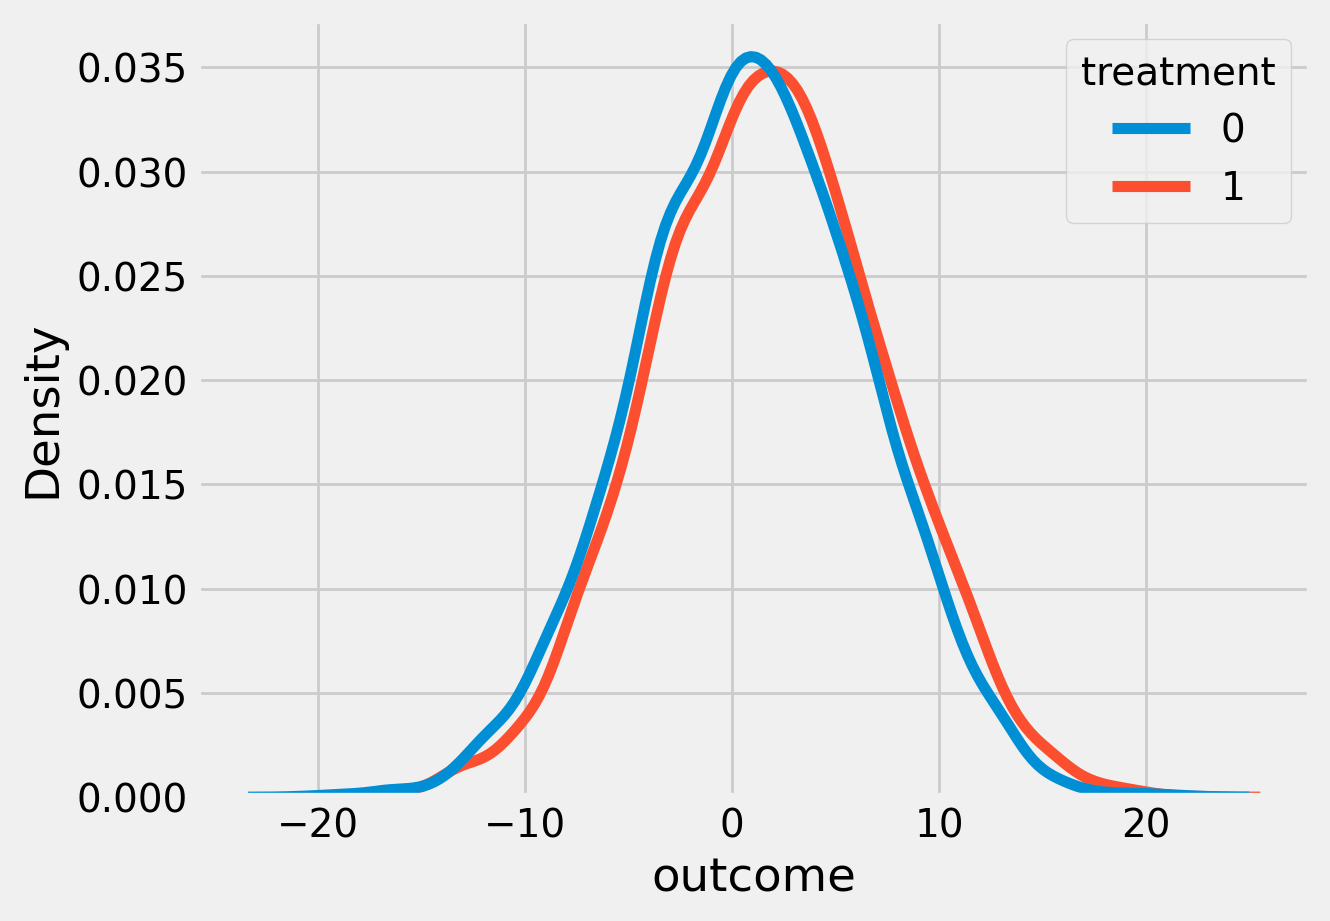

In [9]:
sns.kdeplot(data=df, x='outcome', hue='treatment')
plt.show()

In [10]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11101)
n_test = df_test.shape[0]
n_train = df_train.shape[0]


In [11]:
# Table to gather estimated ITEs by models
df_result = pd.DataFrame({
    'outcome': df_test['outcome'],
    'is_treated': df_test['treatment'],
    'treatment_effect': df_test['treatment_effect']
})
df_result

,outcome,is_treated,treatment_effect
625,3.519424,1,0.819201
5717,-0.456031,0,1.131599
14801,4.479222,0,1.969727
13605,4.523891,0,0.884079
4208,-4.615111,0,1.179124
...,...,...,...
8796,-3.611756,1,0.376329
4964,-3.657272,0,0.646351
6310,7.138665,1,0.879285
2240,-8.170133,1,1.919082


In [12]:

ctrees = {
    'ctree_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'ctree_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.1': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.1,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.25': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.25,
            groups_cnt=True,
        ),
    },
    'ctree_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'ctree_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
}

In [13]:
# Model treatment effect
for ctree_name, ctree_info in ctrees.items():
    print(f"Fitting: {ctree_name}")
    ctree = CausalTreeRegressor(**ctree_info['params'])
    ctree.fit(X=df_train[feature_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['outcome'].values)

    ctrees[ctree_name].update({'model': ctree})
    df_result[ctree_name] = ctree.predict(df_test[feature_names].values)

Fitting: ctree_mse
Fitting: ctree_cmse
Fitting: ctree_cmse_p=0.1
Fitting: ctree_cmse_p=0.25
Fitting: ctree_cmse_p=0.5
Fitting: ctree_ttest


In [14]:
df_result.head()

,outcome,is_treated,treatment_effect,ctree_mse,ctree_cmse,ctree_cmse_p=0.1,ctree_cmse_p=0.25,ctree_cmse_p=0.5,ctree_ttest
625,3.519424,1,0.819201,1.624443,-1.690532,0.129960,-0.947096,-0.947096,-1.690532
5717,-0.456031,0,1.131599,0.809237,0.367659,0.992395,1.978697,1.978697,1.054970
14801,4.479222,0,1.969727,1.624443,-0.778434,3.388318,1.937710,1.937710,1.744661
13605,4.523891,0,0.884079,0.809237,0.367659,0.992395,0.805110,0.805110,1.039292
4208,-4.615111,0,1.179124,0.809237,2.134070,0.992395,0.928345,0.928345,1.054970


In [21]:
def uplift_at_k(y_true, uplift, treatment, strategy, k=0.3):
    """Compute uplift at first k observations by uplift of the total sample.

    Args:
        y_true (1d array-like): Correct (true) binary target values.
        uplift (1d array-like): Predicted uplift, as returned by a model.
        treatment (1d array-like): Treatment labels.
        k (float or int): If float, should be between 0.0 and 1.0 and represent the proportion of the dataset
            to include in the computation of uplift. If int, represents the absolute number of samples.
        strategy (string, ['overall', 'by_group']): Determines the calculating strategy.

            * ``'overall'``:
                The first step is taking the first k observations of all test data ordered by uplift prediction
                (overall both groups - control and treatment) and conversions in treatment and control groups
                calculated only on them. Then the difference between these conversions is calculated.

            * ``'by_group'``:
                Separately calculates conversions in top k observations in each group (control and treatment)
                sorted by uplift predictions. Then the difference between these conversions is calculated



    .. versionchanged:: 0.1.0

        * Add supporting absolute values for ``k`` parameter
        * Add parameter ``strategy``

    Returns:
        float: Uplift score at first k observations of the total sample.

    See also:
        :func:`.uplift_auc_score`: Compute normalized Area Under the Uplift curve from prediction scores.

        :func:`.qini_auc_score`: Compute normalized Area Under the Qini Curve from prediction scores.
    """

    # TODO: checker all groups is not empty
    #check_consistent_length(y_true, uplift, treatment)
    #check_is_binary(treatment)
    #check_is_binary(y_true)
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    strategy_methods = ['overall', 'by_group']
    if strategy not in strategy_methods:
        raise ValueError(f'Uplift score supports only calculating methods in {strategy_methods},'
                         f' got {strategy}.'
                         )

    n_samples = len(y_true)
    order = np.argsort(uplift, kind='mergesort')[::-1]
    _, treatment_counts = np.unique(treatment, return_counts=True)
    n_samples_ctrl = treatment_counts[0]
    n_samples_trmnt = treatment_counts[1]

    k_type = np.asarray(k).dtype.kind

    if (k_type == 'i' and (k >= n_samples or k <= 0)
            or k_type == 'f' and (k <= 0 or k >= 1)):
        raise ValueError(f'k={k} should be either positive and smaller'
                         f' than the number of samples {n_samples} or a float in the '
                         f'(0, 1) range')

    if k_type not in ('i', 'f'):
        raise ValueError(f'Invalid value for k: {k_type}')

    if strategy == 'overall':
        if k_type == 'f':
            n_size = int(n_samples * k)
        else:
            n_size = k

        # ToDo: _checker_ there are observations among two groups among first k
        score_ctrl = y_true[order][:n_size][treatment[order][:n_size] == 0].mean()
        score_trmnt = y_true[order][:n_size][treatment[order][:n_size] == 1].mean()

    else:  # strategy == 'by_group':
        if k_type == 'f':
            n_ctrl = int((treatment == 0).sum() * k)
            n_trmnt = int((treatment == 1).sum() * k)

        else:
            n_ctrl = k
            n_trmnt = k

        if n_ctrl > n_samples_ctrl:
            raise ValueError(f'With k={k}, the number of the first k observations'
                             ' bigger than the number of samples'
                             f'in the control group: {n_samples_ctrl}'
                             )
        if n_trmnt > n_samples_trmnt:
            raise ValueError(f'With k={k}, the number of the first k observations'
                             ' bigger than the number of samples'
                             f'in the treatment group: {n_samples_ctrl}'
                             )

        score_ctrl = y_true[order][treatment[order] == 0][:n_ctrl].mean()
        score_trmnt = y_true[order][treatment[order] == 1][:n_trmnt].mean()

    return score_trmnt - score_ctrl

In [27]:
for ctree_name in list(ctrees.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.01, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 1% = {metric}')

Algorithm name ctree_mse, uplift at 1% = 0.7387586255448949
Algorithm name ctree_cmse, uplift at 1% = 5.045999360394766
Algorithm name ctree_cmse_p=0.1, uplift at 1% = 3.6053461882121765
Algorithm name ctree_cmse_p=0.25, uplift at 1% = 0.782273094132662
Algorithm name ctree_cmse_p=0.5, uplift at 1% = 0.782273094132662
Algorithm name ctree_ttest, uplift at 1% = 5.045999360394766
Algorithm name treatment_effect, uplift at 1% = 4.722114681292634


In [32]:
for ctree_name in list(ctrees.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.05, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 5% = {metric}')

Algorithm name ctree_mse, uplift at 5% = 2.1056186168731315
Algorithm name ctree_cmse, uplift at 5% = 2.444445635267038
Algorithm name ctree_cmse_p=0.1, uplift at 5% = 1.574684435390738
Algorithm name ctree_cmse_p=0.25, uplift at 5% = 3.321619673183883
Algorithm name ctree_cmse_p=0.5, uplift at 5% = 3.321619673183883
Algorithm name ctree_ttest, uplift at 5% = 2.444445635267038
Algorithm name treatment_effect, uplift at 5% = 3.995653394885071


In [33]:
for ctree_name in list(ctrees.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.1, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 10% = {metric}')

Algorithm name ctree_mse, uplift at 10% = 1.840430677655491
Algorithm name ctree_cmse, uplift at 10% = 2.0981890253872897
Algorithm name ctree_cmse_p=0.1, uplift at 10% = 1.8074175198791043
Algorithm name ctree_cmse_p=0.25, uplift at 10% = 2.7441310907661274
Algorithm name ctree_cmse_p=0.5, uplift at 10% = 2.7441310907661274
Algorithm name ctree_ttest, uplift at 10% = 2.373051405929172
Algorithm name treatment_effect, uplift at 10% = 3.6186503641431202


In [28]:
cforests = {
    'cforest_mse': {
        'params':
        dict(criterion='standard_mse',
             control_name=0,
             min_impurity_decrease=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
    'cforest_cmse': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.,
            groups_cnt=True
        ),
    },
    'cforest_cmse_p=0.5': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_cmse_p=0.5_md=3': {
        'params':
        dict(
            criterion='causal_mse',
            control_name=0,
            max_depth=3,
            min_samples_leaf=400,
            groups_penalty=0.5,
            groups_cnt=True,
        ),
    },
    'cforest_ttest': {
        'params':
        dict(criterion='t_test',
             control_name=0,
             min_samples_leaf=400,
             groups_penalty=0.,
             groups_cnt=True),
    },
}

In [29]:
# Model treatment effect
for cforest_name, cforest_info in cforests.items():
    print(f"Fitting: {cforest_name}")
    cforest = CausalRandomForestRegressor(**cforest_info['params'])
    cforest.fit(X=df_train[feature_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['outcome'].values)

    cforests[cforest_name].update({'model': cforest})
    df_result[cforest_name] = cforest.predict(df_test[feature_names].values)

Fitting: cforest_mse
Fitting: cforest_cmse
Fitting: cforest_cmse_p=0.5
Fitting: cforest_cmse_p=0.5_md=3
Fitting: cforest_ttest


In [31]:
for ctree_name in list(cforests.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.01, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 1% = {metric}')

Algorithm name cforest_mse, uplift at 1% = 6.452409763849621
Algorithm name cforest_cmse, uplift at 1% = 2.554877115655575
Algorithm name cforest_cmse_p=0.5, uplift at 1% = 3.448160560722978
Algorithm name cforest_cmse_p=0.5_md=3, uplift at 1% = 4.031443781844743
Algorithm name cforest_ttest, uplift at 1% = 3.9963355775814717
Algorithm name treatment_effect, uplift at 1% = 4.722114681292634


In [34]:
for ctree_name in list(cforests.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.05, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 5% = {metric}')

Algorithm name cforest_mse, uplift at 5% = 3.056586848802351
Algorithm name cforest_cmse, uplift at 5% = 3.2893569445457533
Algorithm name cforest_cmse_p=0.5, uplift at 5% = 3.084251875690447
Algorithm name cforest_cmse_p=0.5_md=3, uplift at 5% = 3.058012922677017
Algorithm name cforest_ttest, uplift at 5% = 3.746615687779105
Algorithm name treatment_effect, uplift at 5% = 3.995653394885071


In [36]:
for ctree_name in list(cforests.keys()) + ['treatment_effect']:
    metric = uplift_at_k(df_result['outcome'].values, df_result[ctree_name].values, df_result['is_treated'].values, k=0.1, strategy='overall')
    print(f'Algorithm name {ctree_name}, uplift at 10% = {metric}')

Algorithm name cforest_mse, uplift at 10% = 2.7540613842894186
Algorithm name cforest_cmse, uplift at 10% = 2.608990135255708
Algorithm name cforest_cmse_p=0.5, uplift at 10% = 2.813863579672656
Algorithm name cforest_cmse_p=0.5_md=3, uplift at 10% = 2.9424080448769714
Algorithm name cforest_ttest, uplift at 10% = 2.8755049256001275
Algorithm name treatment_effect, uplift at 10% = 3.6186503641431202
